# Neural Scattering Fields Demo (TODO)
In this notebook, we use our `lego-mist` scene to demonstrate our multiple-scattering NeRF.\
(Alternatively to this demo, you can also run the model from the command line using `python3 run_nerf.py <path to data> <output path> <environment map path>`)

First, we start by fetching and processing the data (images and poses).\
**NOTE:** utils.load_transforms_json only handles instant-NGP-like json formatting.\
Hence, this will not work out the box with synthetic-NeRF datasets.\
(Take a look at `data/lego_mist/transforms_train.json` file for an example.)

In [2]:
# autoreload imports for dev
%load_ext autoreload
%autoreload 2

In [3]:
import os
import utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# get train and test data
train_dict  = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego_mist"), "transforms_train.json")
test_dict   = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego_mist"), "transforms_test.json")
train_imgs  = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego_mist", "train"))
env_map     = np.array(Image.open("env_map_example.png"))[..., :3]

# Our datasets do not have test_imgs for evaluation.
# Therefore, as a temporary measure, we extract a few images from the training set as test instances.
# Hence, it will be used only to demonstrate novel view synthesis.
# test_imgs   = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego_mist", "test"))

### Camera Pose Visualization
As a sanity check, we can visualize the camera positions and their viewing directions.\
Here, it looks good; all cameras are looking inward towards our scene object.\
We can also visualize our expected test poses: a circular orbit around the scene on the xy plane.

Train poses:


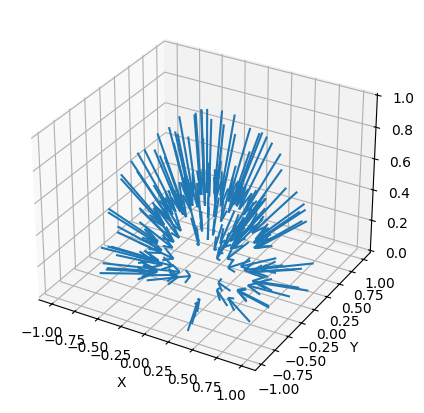

Test poses:


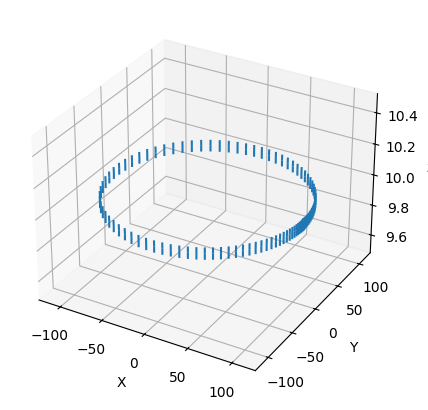

In [4]:
from render import get_camera_poses
import ms_nerf as ms
import torch

train_poses = train_dict["poses"]
test_poses  = test_dict["poses"]
focal_x, focal_y = train_dict["focal"][:]
N_train = train_poses.shape[0]
N_test  = test_poses.shape[0]
H, W = train_imgs[0].shape[:2]
print("Train poses:")
utils.ray_plot(*get_camera_poses(train_poses, transpose=False, normalize=True))
print("Test poses:")
utils.ray_plot(*get_camera_poses(test_poses, transpose=False, normalize=False)) # debug this

## Ray Tracing
Just as a ray tracer does, we shoot a ray through each "pixel" of the virtual image plane.\
This is covered by `get_rays`. Sampling along the ray via volumetric rendering is found in `sample_hierarchical`, made up of two passes as in vanilla NeRF:
- coarse pass (`sample_rays`)
- fine pass (`sample_fine`)

For more information, check out `render.py`.

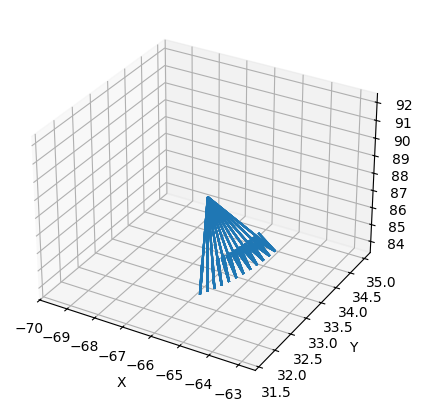

In [ ]:
from render import get_rays

## an example of get_rays output ##
rays_o, rays_d = get_rays(train_poses, H, W, focal_x, focal_y, batched=True)
utils.ray_plot(rays_o.reshape(-1, 3)[0:10000:100, :], rays_d.reshape(-1, 3)[0:10000:100, :], arrow_length=3)


#### Phase function sampling: Henyey-Greenstein (single-scattering) vs Uniform Sampling (multi-scattering)
In multi-scattering NeRF, we add scattering capabilities. This can be done by randomly sampling from a phase function\
per coarse and fine sample positions given by `sample_hierarchical`.

This is what we use to sample rays in single-scattering.\
**NOTE:** Sampling using `sample_next_directions` is relative to the ray coordinate frame.\
These need to be transformed into the world frame by using `local_to_world_rotation`.

[PDF] 0.999 aligned at g=0.99:	 307.8355811394921
[PDF] 0.999 aligned at g=0.9999: 5.627117655687526


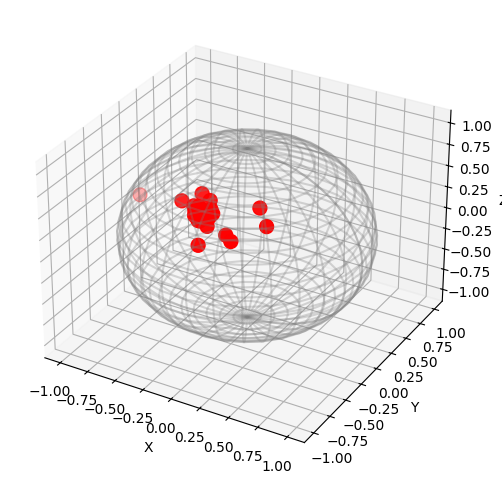

In [6]:
## HG demo ##
from render import henyey_greenstein_pdf, sample_henyey_greenstein
from sh import visualize_spherical_samples
from utils import local_to_world_rotation, spherical_to_cartesian, cartesian_to_spherical


# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
# also, change 'ray_dir' to update the position in world coordinates (NOTE: +z in the plot is upward, unlike our volume renderer) 
ray_dir = torch.tensor([0,-1,1], dtype=torch.float32)  # w.r.t world
g = 0.99

# local to world position
R = local_to_world_rotation(ray_dir.reshape(-1,3))

# NOTE: lots of discrepancy between 0.99 and 0.9999. The sensitivity to change is highly non-linear
# (maybe this could impact training? Maybe there's a transformation that can make this behave better.)
# additonally, if you check the henyey_greenstein_pdf, you can see that if g ~= 1, then even the smallest offset
# of cos_theta can go from extremely high probability density to very low ones.
print("[PDF] 0.999 aligned at g=0.99:\t", henyey_greenstein_pdf(1 - 1e-4, g=0.99))
print("[PDF] 0.999 aligned at g=0.9999:", henyey_greenstein_pdf(1 - 1e-4, g=0.9999))

theta_phi = sample_henyey_greenstein(*torch.rand(2, 128), g=g) # w.r.t the current ray direction
local_dirs = spherical_to_cartesian(theta_phi) # (num_samples, 3)
world_dirs = torch.einsum("bij,kj->bki", R, local_dirs)
theta_phi = cartesian_to_spherical(world_dirs.squeeze(0))
visualize_spherical_samples(*theta_phi.T)

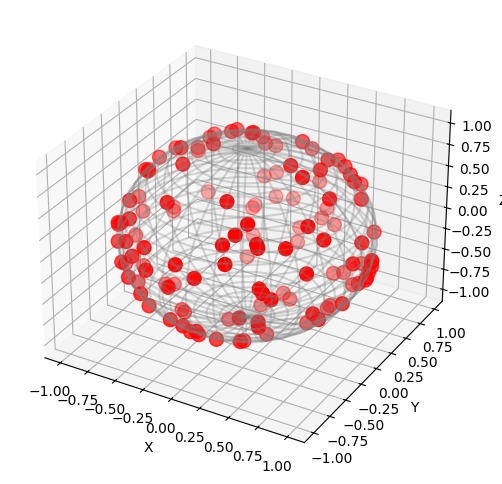

In [7]:
## Uniform Demo ##
from sh import visualize_spherical_samples
from render import sample_isotropic
# because uniform/isotropic distribution, we can forego ray to world frame transformations
# since all directions are equally likely

theta_phi2 = sample_isotropic(*torch.rand(2, 128))
visualize_spherical_samples(*theta_phi2.T)

### Radiance Evaluation

We use **spherical harmonics** to approximate multi-scattering contributions per sample.\
Specifically, we call `eval_sh` to get the radiance using Legendre polynomials and our learned coefficients.

We also directly sample the environment map using `eval_env_map` using sampled directions\
from `sample_isotropic`.

Examples of each are shown below.

This is our original environment map:



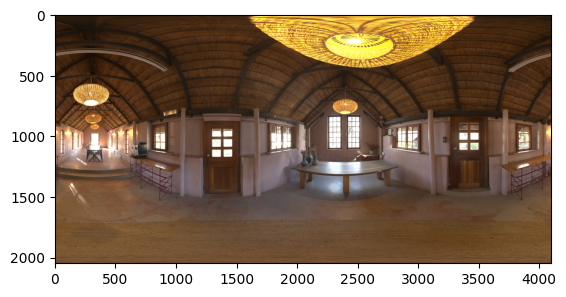

In [8]:
from render import eval_env_map, isotropic_pdf
from sh import project_to_sh, reconstruct_sh_image, plot_sh_texture

print("This is our original environment map:\n")
plt.imshow(env_map)


This is what happens when we transform it into frequency domain using SH:



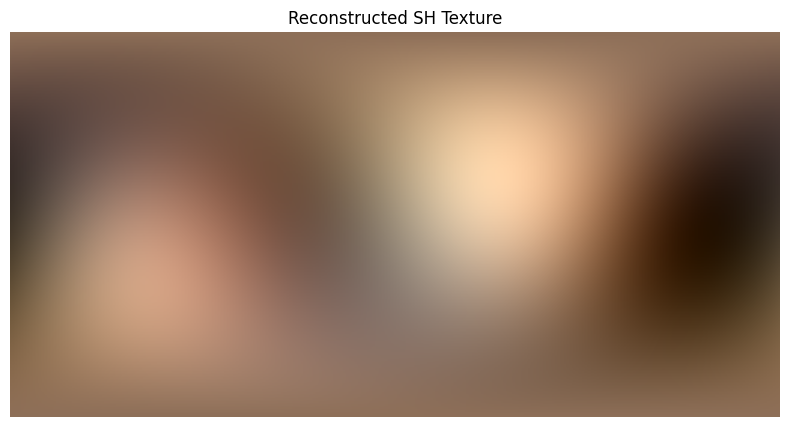

In [9]:
## Demo of spherical harmonic lighting used for multiple scattering ##
# in the model, these coefficients will be learned from the network (SphericalHarmonicMLP)
print("This is what happens when we transform it into frequency domain using SH:\n")
env_map_sh_coefs = project_to_sh(torch.tensor(env_map), phase_function=sample_isotropic, sample_pdf=isotropic_pdf, lmax=2, num_samples=64)
plot_sh_texture(reconstruct_sh_image(env_map_sh_coefs, lmax=2))

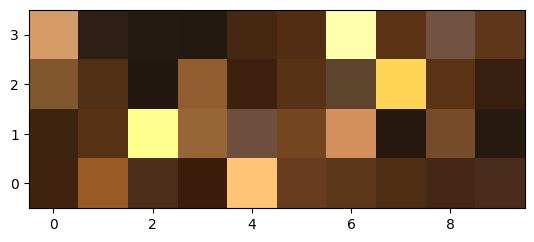

In [10]:
## Demo of single scattering sampling the environment map given 3D directional vectors ##
# in the model, instead of random directions, these will be sampled from the HG phase function
plt.imshow(eval_env_map(torch.rand(4,10,3), torch.tensor(np.array(Image.open("env_map_example.png")))[...,:3]), origin="lower")

## Network
After this, we set up our component modules for our `NeuralScatteringField`, defined in `ms_nerf.py`.

### Positional Encoder
Just like NeRF, we use a fixed sinusoid-based PE to enable the capture of high-fidelity details.

In [ ]:
from ms_nerf import PositionalEncoder

x_encoder = PositionalEncoder(3, 8, include_input=True, device="cpu") # change to 'cuda' when working for real
d_encoder = PositionalEncoder(3, 1, include_input=True, device="cpu") # change to 'cuda' when working for real

# to prevent crashing due to memory constraints, we take 3 tensors:
first3_rays_o = rays_o.reshape(-1, 3)[:3, :]
first3_rays_d = rays_d.reshape(-1, 3)[:3, :]
x_enc = x_encoder(first3_rays_o)
d_enc = d_encoder(first3_rays_d)
print(x_enc.shape, d_enc.shape) # here, we should get (3, 51) and (3, 9) respectively

torch.Size([3, 51]) torch.Size([3, 9])


### Intemediate Networks

### Forward Pass

Below is the same visualization, but using an **isotropic phase function**, which is equivalent to g=0.\
This is used in multiple scattering using the learned SH coefficients from the SH network.

## Training
Here, we borrow training metadata from the *Neural Relightable Participating Media Rendering* (Zheng et al.) paper.\
At the current time of construction, our model is pretty much the same as theirs, except ours is more constrained in only allowing environment map lighting.\
We train the model for 200K iterations, with a batch of 1200 primary rays each batch.\
We also decay the learning rate from $1\times 10^{-4}\to 1\times 10^{-5}$.

In [ ]:
# call training loop from ms_nerf

## Testing
Here, we render the scene using test poses unseen during training.

In [ ]:
# choose some random test poses and render their views